Includes all preprocessing steps for the dataset. The dataset is loaded from the original source, and then the following steps are performed:
- Cleaned
- Normalized
- Text is tokenized
- Text is pos-tagged
- Text is lemmatized

EDA is also performed on the dataset, and the results are saved to the `EDA/` folder.

All the preprocessing steps are saved to the `Preprocessed/` folder.

Modeling is also performed on the dataset, and models are saved. The results are saved to the `Models/` folder.


# **Downloading**

In [1]:
%pip install -r Requirements.txt
!python3 -m nltk.downloader all

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickel (from versions: none)
ERROR: No matching distribution found for pickel

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


In [2]:
!mkdir zip_jester_dataset
!mkdir unzipped_files

!wget -P zip_jester_dataset/ \
https://eigentaste.berkeley.edu/dataset/jester_dataset_1_joke_texts.zip \
https://eigentaste.berkeley.edu/dataset/jester_dataset_1_1.zip \
https://eigentaste.berkeley.edu/dataset/jester_dataset_1_2.zip \
https://eigentaste.berkeley.edu/dataset/jester_dataset_1_3.zip

!echo "Downloaded files into directory"
!unzip 'zip_jester_dataset/*.zip' -d unzipped_files/
!echo "Unzipped all dataset files into unzipped_files directory"

A subdirectory or file zip_jester_dataset already exists.


A subdirectory or file unzipped_files already exists.
'wget' is not recognized as an internal or external command,
operable program or batch file.


"Downloaded files into directory"


'unzip' is not recognized as an internal or external command,
operable program or batch file.


"Unzipped all dataset files into unzipped_files directory"


**Imports**

In [3]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Natural Language Processing
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

# Tools for topic modelling
from pprint import pprint
from operator import itemgetter

# LDA model
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# **Preprocessing**

In [4]:
common_words = ["---","---|---","i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

pos_count = {'ADJ':0, 'ADP':0, 'ADV':0, 'CONJ':0, 'DET':0, 'NOUN':0, 'NUM':0, 'PRT':0, 'PRON':0, 'VERB':0, 'PUNC':0, 'OTHERS':0, 'X':0}

## **Functions**

### **Preprocessing Jokes**

In [5]:
def read_html_files(num_jokes):
    """
    Read and store HTML content from a specified number of joke files.

    Parameters:
    - num_jokes (int): The number of jokes to read and store.

    Returns:
    - dict: A dictionary with joke IDs as keys and HTML content as values.
    """
    
    all_jokes_in_html = {}  # key: joke_id, value: joke_html

    for i in range(1, num_jokes + 1):
        file_path = f'unzipped_files/jokes/init{str(i)}.html'
        with open(file_path) as f:
            all_jokes_in_html[i] = f.read()

    return all_jokes_in_html

def filter_jokes(html_data): #completed
    """
    Extract and filter jokes from HTML content.

    This function takes a dictionary of HTML data where the keys represent joke IDs
    and the values are HTML content containing jokes. It extracts and filters the
    jokes, removing HTML tags and newline characters.

    Parameters:
    html_data (dict): A dictionary where keys are joke IDs and values are HTML content.

    Returns:
    dict: A dictionary containing filtered jokes with IDs as keys.

    Output:
    {1: 'Filtered Joke 1', 2: 'Filtered Joke 2', ...}
    """

    filtered_jokes = {}

    for joke_id, joke_html in html_data.items():
        unfiltered_joke = re.search('<!--begin of joke -->(.*)<!--end of joke -->', joke_html, re.DOTALL).group(1)
        filtered_joke = re.sub('<.*?>', ' ', unfiltered_joke).replace('\n', ' ')
        filtered_jokes[joke_id] = filtered_joke

    return filtered_jokes

def clean_text(text, common_words): # completed
    """
    This function cleans joke text for further preprocesing.
    It first gets individual words from only lower case , alphanumeric text with no extra whitespaces
    then it removes all common words and joins the left out words to form new cleaned text of joke

    Args:
        text (string): input joke text
        common_words (list): list of common words to be removed from joke text
    Returns:
        string: cleaned text
    """
    
    words = re.sub(r"\s+", ' ', re.sub(r'[^\w+\s]', ' ', text.lower())).strip().split(' ')
    new_words = [w for w in words if w not in common_words]
    clean_texts = ' '.join(new_words)

    return clean_texts

# ---------------------------------- TESTING --------------------------------

def lemmenize_text(text, common_words): # completed
    """
    This function lemenize joke text for further preprocesing.
    It first gets individual words from text
    then it lemenizes every word and joins the new words together to form new text of joke

    Args:
        text (string): input joke text
        common_words (list): list of common words to be removed from joke text
    Returns:
        string: lemenized joke text
    """

    print("Lemmenizing Text...")

    lemeniza = WordNetLemmatizer()
    new_words = [lemeniza.lemmatize(w) for w in word_tokenize(text) if w not in common_words]
    lemmenized_text = ' '.join(new_words)

    return lemmenized_text

def posTag_jokes(text): # completed
    """
    This function generates postags from joke text for further preprocesing.
    It first gets individual words from text
    then it finds postag for every word
    and then it filters out only nouns and verbs from them and joins them in a string

    Args:
        text (string): input joke text
    Returns:
        (sting):  a chain of words conatining only nouns and verbs
    """
    
    print("Generating POS Tags...")

    text = pos_tag(word_tokenize(text), tagset='universal')
    
    new_word = []

    for i in text:
        pos_count[i[1]]+=1
        if len(i[0]) > 1 and (i[1] == 'NOUN' or i[1] == 'VERB'):
            new_word.append(i[0])
    pos_tagged_text = ' '.join(new_word)

    print("Pos tagging complete and filtered.")

    return pos_tagged_text

def preprocess_joke(text, common_words): # completed
    """
    This function preprocess joke text to make it ready for Topic modeling

    Args:
        text (string): input joke text
        common_words (list): list of common words to be removed from joke text

    Returns:
        (sting):  a chain of words conatining only nouns and verbs
    """

    cleaned = clean_text(text, common_words)
    lemmenized = lemmenize_text(cleaned, common_words)
    pos_tagged = posTag_jokes(lemmenized)
    preprocessed = pos_tagged

    return preprocessed


# <------------------------------ LDA ------------------------------------->

def LDA_model_processing(dataframe,common_words):
    """
        Topic modeling process to be done using LDA
    Args:
        dataframe (pd.DataFrame):  dataframe of jokes
        common_words (list): list of common words to be removed from joke text
    Returns:
        LDA_dataframe_joke (pd.DataFrame): dataframe of jokes after topic modeling
    """
    
    LDA_dataframe_joke = dataframe.copy()
    LDA_dataframe_joke['Processed_joke'] = LDA_dataframe_joke['joke'].apply(lambda x: preprocess_joke(x,common_words))
    
    # Processed jokes
    print("Processed Jokes included in Joke Dataframe: ")
    display(LDA_dataframe_joke)


    tokens = [d.split() for d in LDA_dataframe_joke['Processed_joke'].tolist()]
    dictionary = Dictionary(tokens)
    corpus=[dictionary.doc2bow(token) for token in tokens]

    print("Tokens: ")
    pprint(tokens)
    print("Dictionary: ")
    pprint(dictionary)
    print("Corpus: ")
    pprint(corpus)
    print("Corpus[0]: ")
    pprint(corpus[0])
    

# LDA Model
      
    temp = dictionary[0]  # This is only to "load" the dictionary.

    id2token_method=dictionary.id2token
    num_of_topics = 10
    model = LdaModel(corpus=corpus, id2word=id2token_method, chunksize=2000, alpha='auto', eta='auto', iterations=400, num_topics=num_of_topics, passes=20, eval_every= None  # Don't evaluate model perplexity, takes too much time.
                     )

    print("Model Training Complete. ")
    
    top_topics = model.top_topics(corpus) #, num_words=20)
    print("Top Topics: ")
    pprint(top_topics)
    
    # saving the model using LDA
    model.save('Models/lda_model')
    print("Model Saved.")

    # Clustering
    verbs_and_nouns = LDA_dataframe_joke['Processed_joke'].tolist()
    cluster = [model.get_document_topics(dictionary.doc2bow(d.split()), minimum_probability = 0.0) for d in verbs_and_nouns]
    LDA_dataframe_joke['cluster'] = pd.Series(cluster)

    print("Clustered Dataframe: ")
    display(LDA_dataframe_joke)
    
    # Sorting Topics based on Probability
    sorted_topics = [(sorted(LDA_dataframe_joke['cluster'][i],key=itemgetter(1),  reverse=True)) for i in range(len(dataframe))]
    LDA_dataframe_joke['sorted_topics'] = pd.Series(sorted_topics)
    
    # Finding Main Topic for each Joke
    maximum_probability_topic = [LDA_dataframe_joke['sorted_topics'][i][0][0] for i in range(len(dataframe))]
    LDA_dataframe_joke['main_topic'] = maximum_probability_topic

    print("Main Topic Dataframe: ")
    display(LDA_dataframe_joke)
    
    return LDA_dataframe_joke, dictionary

### **Preprocessing Ratings**

In [6]:
def create_ratings_dataframe():
    """
    Process joke ratings and create a DataFrame.

    It reads jester-datasets from unziped_files folder and handels un-rated cases and then organizes them
    into a DataFrame where it also adds a user ID and joke labels to the columns.

    Parameters:
    This function takes no parameters.

    Returns:
     A pd.DataFrame: A DataFrame with user IDs, joke ratings, and labeled columns.
     A dictionary: A dictionary having ratings per joke(for eda)

    """
    ratings_per_joke = {}
    rating_sheet_1 = pd.read_excel('unzipped_files/jester-data-1.xls', header=None).to_numpy()
    rating_sheet_2 = pd.read_excel('unzipped_files/jester-data-2.xls', header=None).to_numpy()
    rating_sheet_3 = pd.read_excel('unzipped_files/jester-data-3.xls', header=None).to_numpy()
    
    length_1 = range(rating_sheet_1.shape[0])
    length_2 = range(rating_sheet_2.shape[0])
    length_3 = range(rating_sheet_3.shape[0])
    
    ratings = [i+1 for i in range(rating_sheet_1.shape[0] + rating_sheet_2.shape[0] + rating_sheet_3.shape[0])]
    
    for i in range(1,101):
        num_rated_jokes=0

        for j in length_1:
            if(rating_sheet_1[j][i] == 99):
                rating_sheet_1[j][i]=np.nan
            else:
                num_rated_jokes += 1
        for j in length_2:
            if(rating_sheet_2[j][i] == 99):
                rating_sheet_2[j][i] = np.nan
            else:
                num_rated_jokes += 1
        for j in length_3:
            if(rating_sheet_3[j][i] == 99):
                rating_sheet_3[j][i] = np.nan
            else:
                num_rated_jokes +=1

        ratings_per_joke['joke_'+ str(i)] = num_rated_jokes
    
    merged_ratings = pd.DataFrame(np.concatenate((rating_sheet_1,rating_sheet_2,rating_sheet_3),axis=0))
    merged_ratings.columns = ['number_of_jokes_rated']+['joke_'+ str(i+1) for i in range(100)]
    merged_ratings.insert(0, 'user_id', ratings)

    return merged_ratings, ratings_per_joke

def robust_scaling(dataframe):
    """
    function does robust scalling of joke ratings

    Args:
        df1 (pd.DataFrame): input dataframe of joke ratings

    Returns:
        df (pd.DataFrame): Normalized Dataframe of joke ratings
    """
    dataframe_scaled_ratings = (dataframe.to_numpy())[:,2:]
    df_mean_rating = np.mean(dataframe_scaled_ratings, axis=1)
    df_std_dev= np.std(dataframe_scaled_ratings, axis=1)
    for i in range(100):
        dataframe_scaled_ratings[:,i]= (dataframe_scaled_ratings[:,i] - df_mean_rating[i])/df_std_dev[i]
    print("Robust Scaling Done.")

    # print("Quantile Scaling Started.")
    # df_quantile1 = np.quantile(dataframe_scaled_ratings,0.25, axis=1)
    # df_quantile3 = np.quantile(dataframe_scaled_ratings,0.75, axis=1)
    # for i in range(100):
    #     dataframe_scaled_ratings[:,i] = (dataframe_scaled_ratings[:,i]-df_quantile1[i])/(df_quantile3[i]-df_quantile1[i])
        
    dataframe_scaled_ratings=pd.DataFrame(dataframe_scaled_ratings)
    dataframe_scaled_ratings.insert(0, "number_of_jokes_rated", dataframe['number_of_jokes_rated'])
    dataframe_scaled_ratings.insert(0, "user_id", dataframe['user_id'])
    dataframe_scaled_ratings.columns=['user_id','number_of_jokes_rated']+['joke_'+str(i+1) for i in range(100)]
    # print("Quantile Scaling Done.")
    
    return dataframe_scaled_ratings

def normalize_and_fill_0(dataframe):
    """
    Perform Normalization on the given DataFrame

    This function will do normalization on the given dataframe of jokes. It will also fill NaN values with 0.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.

    Returns:
    ratings_dataframe_normalized_ratings (pd.DataFrame): The Normalized DataFrame.
    """
    ratings_dataframe_normalized_ratings = dataframe.copy()
    ratings_dataframe_normalized_ratings = ratings_dataframe_normalized_ratings.drop(columns=['user_id','number_of_jokes_rated'])

    ratings_dataframe_normalized_ratings = ratings_dataframe_normalized_ratings.fillna(0)
    print("Normalization Done by replacing NANs with 0s.")
    
    ratings_dataframe_normalized_ratings = preprocessing.normalize(ratings_dataframe_normalized_ratings)
    ratings_dataframe_normalized_ratings = pd.DataFrame(ratings_dataframe_normalized_ratings)
    ratings_dataframe_normalized_ratings.insert(0, "number_of_jokes_rated", dataframe['number_of_jokes_rated'])
    ratings_dataframe_normalized_ratings.insert(0, "user_id", dataframe['user_id'])
    ratings_dataframe_normalized_ratings.columns=['user_id','number_of_jokes_rated']+['joke_'+str(i+1) for i in range(100)]
    
    # non_normalized but nan handeled dataset
    ratings_df_non_normalized=(dataframe.copy()).fillna(0)
    print("Non Normalized but NANs replaced with 0s.")
    
    return ratings_dataframe_normalized_ratings, ratings_df_non_normalized

### **Miscellanous**

In [7]:
# def dataFrame_to_3el_tuple(df):
#     """
#     creates a 3 element tuple from dataframe_ratings_normalized, where first element is user_id, second element is joke_id, third element is rating
#     Then it sorts this tupple collection on basis of  user_id
#     At last it saves that tupple in csv format
#     Args:
#         df (pd.DataFrame): Dataframe of joke ratings
#     Return:
#         X (pd.DataFrame): Tupple (Dataframe) of 3 elements
#     """
#     # creation of Tupple
#     X = pd.DataFrame()
#     for i in range(1, 101):
#         X = pd.concat([X, pd.DataFrame({'user_id': df['user_id'], 'joke_id': i, 'rating': df['joke_' + str(i)]})], ignore_index=True)
#     # sort X by user_id
#     X = X.sort_values(by=['user_id'])
#     X = X.reset_index(drop=True)
#     # save X to csv
#     X.to_csv('X.csv', index=False)
#     return X

## **Dataframe: Jokes**

In [8]:
num_of_jokes = 100
all_100_jokes_html = read_html_files(num_of_jokes)

print("Number of jokes read: ", len(all_100_jokes_html))
print("First joke: ", all_100_jokes_html[1])

Number of jokes read:  100
First joke:  <HTML>
<HEAD>
<TITLE>Joke 1 of 25</TITLE>
</HEAD>

<BODY TEXT="black" BGCOLOR="#fddf84">

<center>
<TABLE WIDTH="620" CELLSPACING="0" CELLPADDING="0">
<TD WIDTH="470">
<Font Size="+1"> <BR> 
<!--begin of joke -->
A man visits the doctor. The doctor says "I have bad news for you.You have
cancer and Alzheimer's disease". <P>
The man replies "Well,thank God I don't have cancer!"
<!--end of joke -->
</TD></TABLE>
</center>
</BODY>
</HTML>




In [9]:
filtered_dictionary = filter_jokes(all_100_jokes_html)

print("Number of jokes filtered: ", len(filtered_dictionary))
print("First Filtered joke: ", filtered_dictionary[1])

Number of jokes filtered:  100
First Filtered joke:   A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer's disease".   The man replies "Well,thank God I don't have cancer!" 


In [10]:
jokes = filtered_dictionary

dataframe_jokes = pd.DataFrame([[j,jokes[j]] for j in jokes])
dataframe_jokes.columns=['joke_id','joke']

LDA_dataframe_jokes, dictionary_map = LDA_model_processing(dataframe_jokes,common_words)

print("LDA_dataframe_jokes:")
display(LDA_dataframe_jokes)

Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete and filtered.
Lemmenizing Text...
Generating POS Tags...
Pos tagging complete 

,joke_id,joke,Processed_joke
0,1,"A man visits the doctor. The doctor says ""I h...",man visit doctor doctor say news cancer alzhei...
1,2,This couple had an excellent relationship goi...,excellent relationship going day came home wor...
2,3,Q. What's 200 feet long and has 4 teeth? A...,foot teeth row nelson concert
3,4,Q. What's the difference between a man and a ...,difference man toilet toilet doesn follow use
4,5,Q.\tWhat's O. J. Simpson's Internet address? ...,internet address slash slash backslash slash s...
...,...,...,...
95,96,Two attorneys went into a diner and ordered t...,attorney went ordered drink produced briefcase...
96,97,A teacher is explaining to her class how diff...,explaining class language use say language fol...
97,98,Age and Womanhood 1. Between the ages of 13...,age womanhood age nbsp africa virgin unexplore...
98,99,A bus station is where a bus stops. A train ...,bus station bus stop train station train stop ...


Tokens: 
[['man',
  'visit',
  'doctor',
  'doctor',
  'say',
  'news',
  'cancer',
  'alzheimer',
  'disease',
  'man',
  'reply',
  'god',
  'cancer'],
 ['excellent',
  'relationship',
  'going',
  'day',
  'came',
  'home',
  'work',
  'find',
  'packing',
  'asked',
  'leaving',
  'heard',
  'thing',
  'could',
  'said',
  'make',
  'move',
  'told',
  'pedophile',
  'replied',
  'word',
  'year'],
 ['foot', 'teeth', 'row', 'nelson', 'concert'],
 ['difference', 'man', 'toilet', 'toilet', 'doesn', 'follow', 'use'],
 ['internet',
  'address',
  'slash',
  'slash',
  'backslash',
  'slash',
  'slash',
  'escape'],
 ['bill',
  'trip',
  'arkansas',
  're',
  'gas',
  'bill',
  'service',
  'station',
  'town',
  'run',
  'station',
  'serve',
  'realizes',
  'boyfriend',
  'school',
  'attendant',
  'gas',
  'car',
  'window',
  'say',
  'bye',
  'bill',
  'pull',
  'car',
  'road',
  'turn',
  'say',
  'aren',
  'glad',
  'married',
  'could',
  've',
  'wife',
  'grease',
  'replied'

,joke_id,joke,Processed_joke,cluster
0,1,"A man visits the doctor. The doctor says ""I h...",man visit doctor doctor say news cancer alzhei...,"[(0, 0.0020770282), (1, 0.0020696681), (2, 0.0..."
1,2,This couple had an excellent relationship goi...,excellent relationship going day came home wor...,"[(0, 0.0012401268), (1, 0.0012357323), (2, 0.0..."
2,3,Q. What's 200 feet long and has 4 teeth? A...,foot teeth row nelson concert,"[(0, 0.0051912805), (1, 0.005172885), (2, 0.00..."
3,4,Q. What's the difference between a man and a ...,difference man toilet toilet doesn follow use,"[(0, 0.003775904), (1, 0.0037625239), (2, 0.00..."
4,5,Q.\tWhat's O. J. Simpson's Internet address? ...,internet address slash slash backslash slash s...,"[(0, 0.003322909), (1, 0.003311134), (2, 0.004..."
...,...,...,...,...
95,96,Two attorneys went into a diner and ordered t...,attorney went ordered drink produced briefcase...,"[(0, 0.9822341), (1, 0.0015921404), (2, 0.0020..."
96,97,A teacher is explaining to her class how diff...,explaining class language use say language fol...,"[(0, 0.0014325128), (1, 0.0014274366), (2, 0.0..."
97,98,Age and Womanhood 1. Between the ages of 13...,age womanhood age nbsp africa virgin unexplore...,"[(0, 0.9883056), (1, 0.0010480266), (2, 0.0013..."
98,99,A bus station is where a bus stops. A train ...,bus station bus stop train station train stop ...,"[(0, 0.0024434542), (1, 0.9728226), (2, 0.0031..."


Main Topic Dataframe: 


,joke_id,joke,Processed_joke,cluster,sorted_topics,main_topic
0,1,"A man visits the doctor. The doctor says ""I h...",man visit doctor doctor say news cancer alzhei...,"[(0, 0.0020770282), (1, 0.0020696681), (2, 0.0...","[(4, 0.97802085), (7, 0.0029581932), (8, 0.002...",4
1,2,This couple had an excellent relationship goi...,excellent relationship going day came home wor...,"[(0, 0.0012401268), (1, 0.0012357323), (2, 0.0...","[(3, 0.9862362), (4, 0.0019060139), (7, 0.0017...",3
2,3,Q. What's 200 feet long and has 4 teeth? A...,foot teeth row nelson concert,"[(0, 0.0051912805), (1, 0.005172885), (2, 0.00...","[(9, 0.94299525), (4, 0.007978743), (7, 0.0073...",9
3,4,Q. What's the difference between a man and a ...,difference man toilet toilet doesn follow use,"[(0, 0.003775904), (1, 0.0037625239), (2, 0.00...","[(7, 0.95961773), (4, 0.0058033788), (8, 0.005...",7
4,5,Q.\tWhat's O. J. Simpson's Internet address? ...,internet address slash slash backslash slash s...,"[(0, 0.003322909), (1, 0.003311134), (2, 0.004...","[(5, 0.9637167), (4, 0.0051071476), (7, 0.0047...",5
...,...,...,...,...,...,...
95,96,Two attorneys went into a diner and ordered t...,attorney went ordered drink produced briefcase...,"[(0, 0.9822341), (1, 0.0015921404), (2, 0.0020...","[(0, 0.9822341), (4, 0.0024557435), (7, 0.0022...",0
96,97,A teacher is explaining to her class how diff...,explaining class language use say language fol...,"[(0, 0.0014325128), (1, 0.0014274366), (2, 0.0...","[(7, 0.98467964), (4, 0.0022017017), (8, 0.001...",7
97,98,Age and Womanhood 1. Between the ages of 13...,age womanhood age nbsp africa virgin unexplore...,"[(0, 0.9883056), (1, 0.0010480266), (2, 0.0013...","[(0, 0.9883056), (4, 0.0016164934), (7, 0.0014...",0
98,99,A bus station is where a bus stops. A train ...,bus station bus stop train station train stop ...,"[(0, 0.0024434542), (1, 0.9728226), (2, 0.0031...","[(1, 0.9728226), (4, 0.0037554689), (7, 0.0034...",1


LDA_dataframe_jokes:


,joke_id,joke,Processed_joke,cluster,sorted_topics,main_topic
0,1,"A man visits the doctor. The doctor says ""I h...",man visit doctor doctor say news cancer alzhei...,"[(0, 0.0020770282), (1, 0.0020696681), (2, 0.0...","[(4, 0.97802085), (7, 0.0029581932), (8, 0.002...",4
1,2,This couple had an excellent relationship goi...,excellent relationship going day came home wor...,"[(0, 0.0012401268), (1, 0.0012357323), (2, 0.0...","[(3, 0.9862362), (4, 0.0019060139), (7, 0.0017...",3
2,3,Q. What's 200 feet long and has 4 teeth? A...,foot teeth row nelson concert,"[(0, 0.0051912805), (1, 0.005172885), (2, 0.00...","[(9, 0.94299525), (4, 0.007978743), (7, 0.0073...",9
3,4,Q. What's the difference between a man and a ...,difference man toilet toilet doesn follow use,"[(0, 0.003775904), (1, 0.0037625239), (2, 0.00...","[(7, 0.95961773), (4, 0.0058033788), (8, 0.005...",7
4,5,Q.\tWhat's O. J. Simpson's Internet address? ...,internet address slash slash backslash slash s...,"[(0, 0.003322909), (1, 0.003311134), (2, 0.004...","[(5, 0.9637167), (4, 0.0051071476), (7, 0.0047...",5
...,...,...,...,...,...,...
95,96,Two attorneys went into a diner and ordered t...,attorney went ordered drink produced briefcase...,"[(0, 0.9822341), (1, 0.0015921404), (2, 0.0020...","[(0, 0.9822341), (4, 0.0024557435), (7, 0.0022...",0
96,97,A teacher is explaining to her class how diff...,explaining class language use say language fol...,"[(0, 0.0014325128), (1, 0.0014274366), (2, 0.0...","[(7, 0.98467964), (4, 0.0022017017), (8, 0.001...",7
97,98,Age and Womanhood 1. Between the ages of 13...,age womanhood age nbsp africa virgin unexplore...,"[(0, 0.9883056), (1, 0.0010480266), (2, 0.0013...","[(0, 0.9883056), (4, 0.0016164934), (7, 0.0014...",0
98,99,A bus station is where a bus stops. A train ...,bus station bus stop train station train stop ...,"[(0, 0.0024434542), (1, 0.9728226), (2, 0.0031...","[(1, 0.9728226), (4, 0.0037554689), (7, 0.0034...",1


In [11]:
with open('Models/dictionary_map.txt', 'w') as f:
    for key, value in dictionary_map.items():
        f.write('%s:%s\n' % (key, value))

## **Dataframe: Ratings**

In [12]:
dataframe_merged_ratings, dataframe_ratings = create_ratings_dataframe()

print("Joke 1 ratings with NAN:")
display(dataframe_ratings['joke_1'])

Joke 1 ratings with NAN:


32024

In [13]:
# Merged Dataframe

print("Shape of merged_dataframe with NAN:", dataframe_merged_ratings.shape)
display(dataframe_merged_ratings)

Shape of merged_dataframe with NAN: (73421, 102)


,user_id,number_of_jokes_rated,joke_1,joke_2,joke_3,joke_4,joke_5,joke_6,joke_7,joke_8,...,joke_91,joke_92,joke_93,joke_94,joke_95,joke_96,joke_97,joke_98,joke_99,joke_100
0,1,74.0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,2,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,3,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,4,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,5,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73416,73417,21.0,NaN,NaN,NaN,NaN,5.78,8.45,NaN,8.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73417,73418,16.0,NaN,NaN,NaN,NaN,5.24,NaN,NaN,5.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73418,73419,35.0,NaN,NaN,NaN,NaN,-3.93,NaN,-9.03,-2.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73419,73420,21.0,NaN,NaN,NaN,NaN,9.42,9.66,NaN,9.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
robust_scaled_ratings = robust_scaling(dataframe_merged_ratings)

Robust Scaling Done.


# **Exploratory Data Analysis**

In [15]:
def perform_eda(df):
    """
    Perform Exploratory Data Analysis (EDA) on the given DataFrame.

    This function will provide summary statistics, missing value analysis, and
    create data visualizations like histograms, box plots, and correlation matrices.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.

    Returns:
    None
    """
    # Summary statistics
    print("Summary Statistics:")
    description = df.describe()
    display(description)

    # Missing value analysis
    print("\nMissing Value Analysis:")
    missing_data = df.isnull().sum()
    display(missing_data[missing_data > 0])
    return description

## **Histograms**

In [16]:
def plot_numeric_histograms(df, b1):
    """
    Plot histograms for numeric columns in the DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing numeric data.

    Returns:
    None
    """
    plt.figure(figsize=(20, 80))
    # df.select_dtypes(include=[np.number]).hist(bins=20)
    for i in range(1,101):
      plt.subplot(25,4,i)
      plt.hist(df['joke_'+str(i)])
      plt.title('joke_'+str(i))
      plt.title("Histogram of Numeric Columns")
    plt.tight_layout()
    # save the plot in pdf
    if b1 == 0:
      plt.savefig('EDA/histograms_non_normalized_ratings.pdf', format = 'pdf', bbox_inches='tight')
    else:
      plt.savefig('EDA/histograms_normalized_ratings.pdf', format = 'pdf', bbox_inches='tight')
    plt.show()


## **Box Plots**

In [17]:
def plot_numeric_box_plots(df,description,b1):
    """
    Plot box plots for numeric columns in the DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing numeric data.

    Returns:
    None
    """
    plt.figure(figsize=(20, 80))
    for i in range(1,101):
      plt.subplot(25,4,i)
      plt.boxplot(description['joke_'+str(i)][4:].to_numpy())
      plt.title(f'Box Plot of joke_{i}')
      plt.ylabel('Values')
    plt.title("Box Plots of Numeric Columns")
    plt.tight_layout()
    # save the plot
    if b1 == 0:
      plt.savefig('EDA/boxplots_non_normalized_ratings.pdf', format = 'pdf', bbox_inches='tight')
    else:
      plt.savefig('EDA/boxplots_normalized_ratings.pdf', format = 'pdf', bbox_inches='tight')
    plt.show()


## **Correlation Matrix**

In [18]:
def plot_correlation_matrix(df):
    """
    Plot the correlation matrix for numeric columns in the DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing numeric data.

    Returns:
    None
    """
    plt.figure(figsize=(6, 6))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.savefig("Figures/confusion_matrix.pdf", format="pdf", bbox_inches="tight")
    plt.show()

## **Violin**

In [19]:
def create_violin_plot(data, title="Violin Plot", xlabel="Variable", ylabel="Value", rotation=0):
    """
    Create a violin plot from a melted DataFrame.

    Parameters:
    data (pd.DataFrame): The melted DataFrame.
    title (str): The title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    rotation (int): Rotation angle for x-axis labels.

    Returns:
    None
    """
    sns.set(style="darkgrid")
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set(font_scale=1.3)

    data_melted = pd.melt(data, id_vars=['user_id'], value_vars=['joke_' + str(i) for i in range(1, 101)])

    ax = sns.violinplot(x="variable", y="value", data=data_melted)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## **EDA: Ratings**

### **Before Normalization**

In [20]:
print("Before Normalization")
description = perform_eda(dataframe_merged_ratings)

# Save the description to a CSV file
description.to_csv('EDA/description_non_normalized_ratings.csv')

Before Normalization
Summary Statistics:


,user_id,number_of_jokes_rated,joke_1,joke_2,joke_3,joke_4,joke_5,joke_6,joke_7,joke_8,...,joke_91,joke_92,joke_93,joke_94,joke_95,joke_96,joke_97,joke_98,joke_99,joke_100
count,73421.000000,73421.000000,32024.000000,35277.000000,32402.000000,30512.000000,73405.000000,39599.000000,73401.000000,73411.000000,...,20934.000000,21214.000000,21506.000000,21792.000000,21991.000000,22163.000000,22556.000000,22708.000000,23188.000000,19494.000000
mean,36711.000000,56.337560,0.901997,0.162989,0.193411,-1.412599,0.235352,1.330277,-0.633947,-0.996267,...,1.907076,1.121782,2.250618,1.082964,1.034981,1.373027,1.489106,0.869864,-0.036189,1.116812
std,21194.961394,29.015686,5.242998,5.627972,5.448998,5.276202,5.302902,4.976994,5.610902,4.968263,...,5.163324,5.161332,4.736524,5.189511,5.201244,4.895298,5.090773,5.361475,5.232240,5.327569
min,1.000000,15.000000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,...,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000
25%,18356.000000,29.000000,-2.820000,-4.510000,-4.220000,-5.970000,-4.030000,-1.750000,-5.870000,-5.190000,...,-1.210000,-2.520000,-0.340000,-2.520000,-2.670000,-1.550000,-1.600000,-3.160000,-4.220000,-2.770000
50%,36711.000000,52.000000,1.600000,0.730000,0.680000,-1.410000,0.920000,1.890000,-0.290000,-0.630000,...,2.770000,1.800000,2.910000,1.650000,1.700000,1.990000,2.230000,1.500000,0.340000,1.840000
75%,55066.000000,75.000000,5.050000,4.850000,4.560000,2.570000,4.370000,5.240000,3.880000,2.770000,...,6.120000,5.290000,5.920000,5.190000,5.190000,5.150000,5.530000,5.252500,3.980000,5.490000
max,73421.000000,100.000000,9.610000,9.370000,9.610000,9.370000,9.510000,9.660000,10.000000,9.760000,...,9.560000,9.610000,9.370000,9.420000,9.370000,9.370000,9.370000,9.370000,9.810000,9.370000



Missing Value Analysis:


joke_1      41397
joke_2      38144
joke_3      41019
joke_4      42909
joke_5         16
            ...  
joke_96     51258
joke_97     50865
joke_98     50713
joke_99     50233
joke_100    53927
Length: 100, dtype: int64

In [21]:
dataframe_without_count = dataframe_merged_ratings.copy()
dataframe_without_count = dataframe_without_count.drop(columns=['number_of_jokes_rated'])
dataframe_without_count.columns= ['user_id'] + ['joke_'+str(i+1) for i in range(100)]

#### **Histograms**

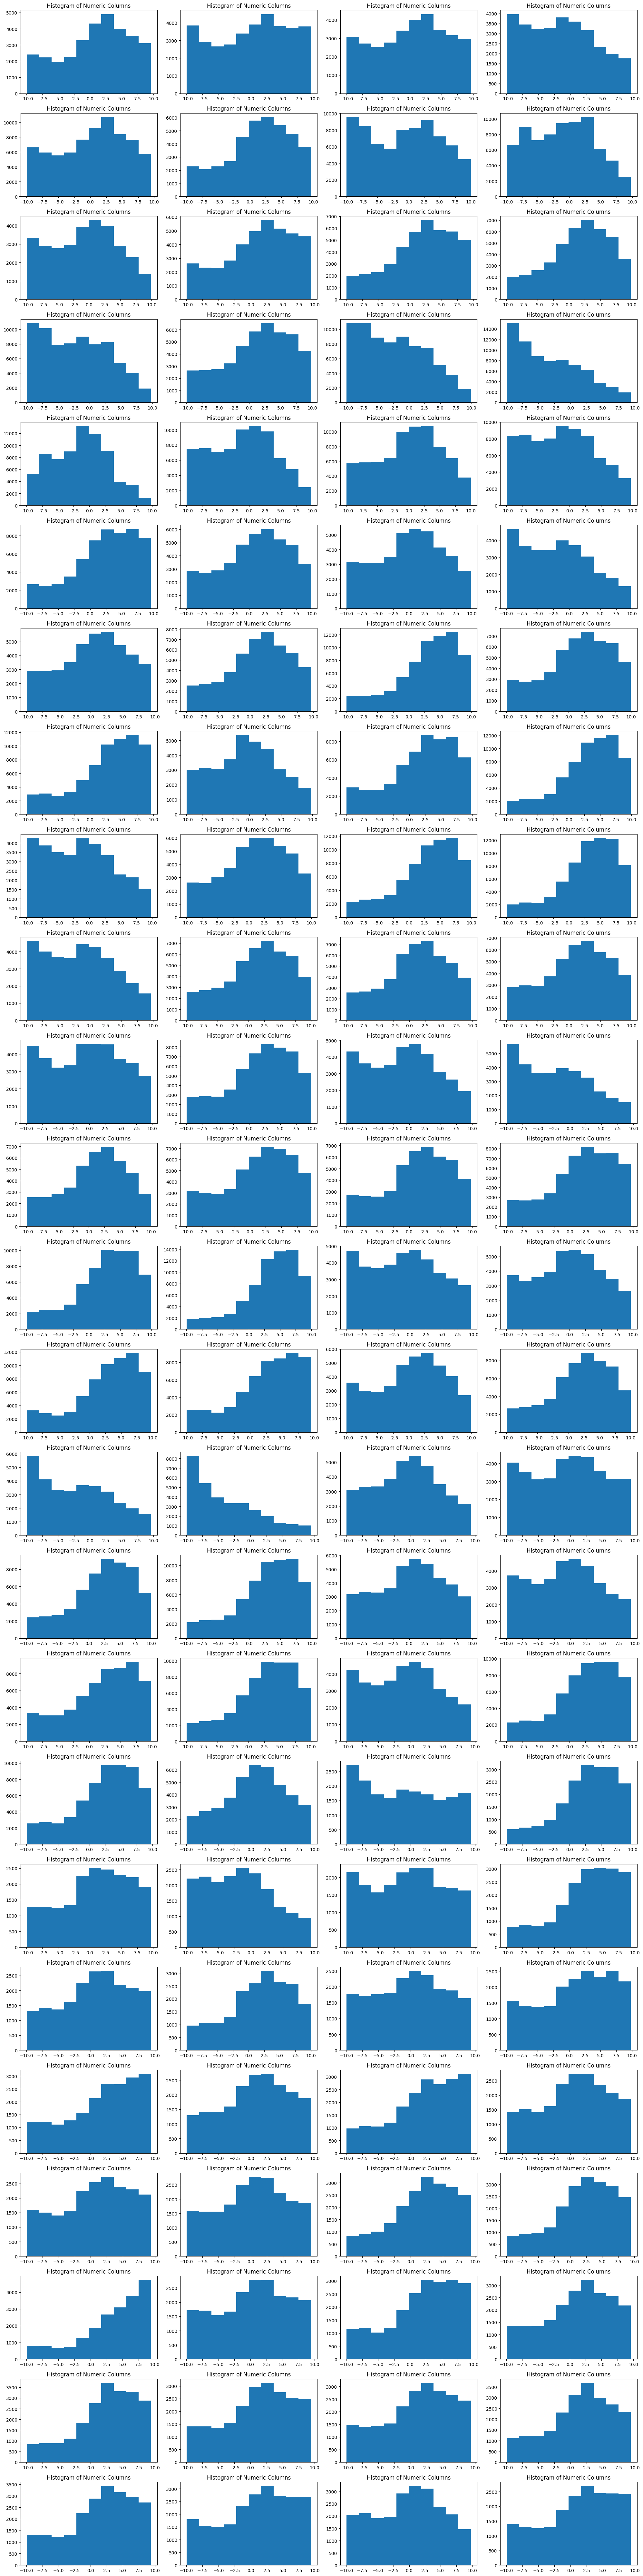

In [22]:
plot_numeric_histograms(dataframe_without_count, 0)

#### **Box Plots**

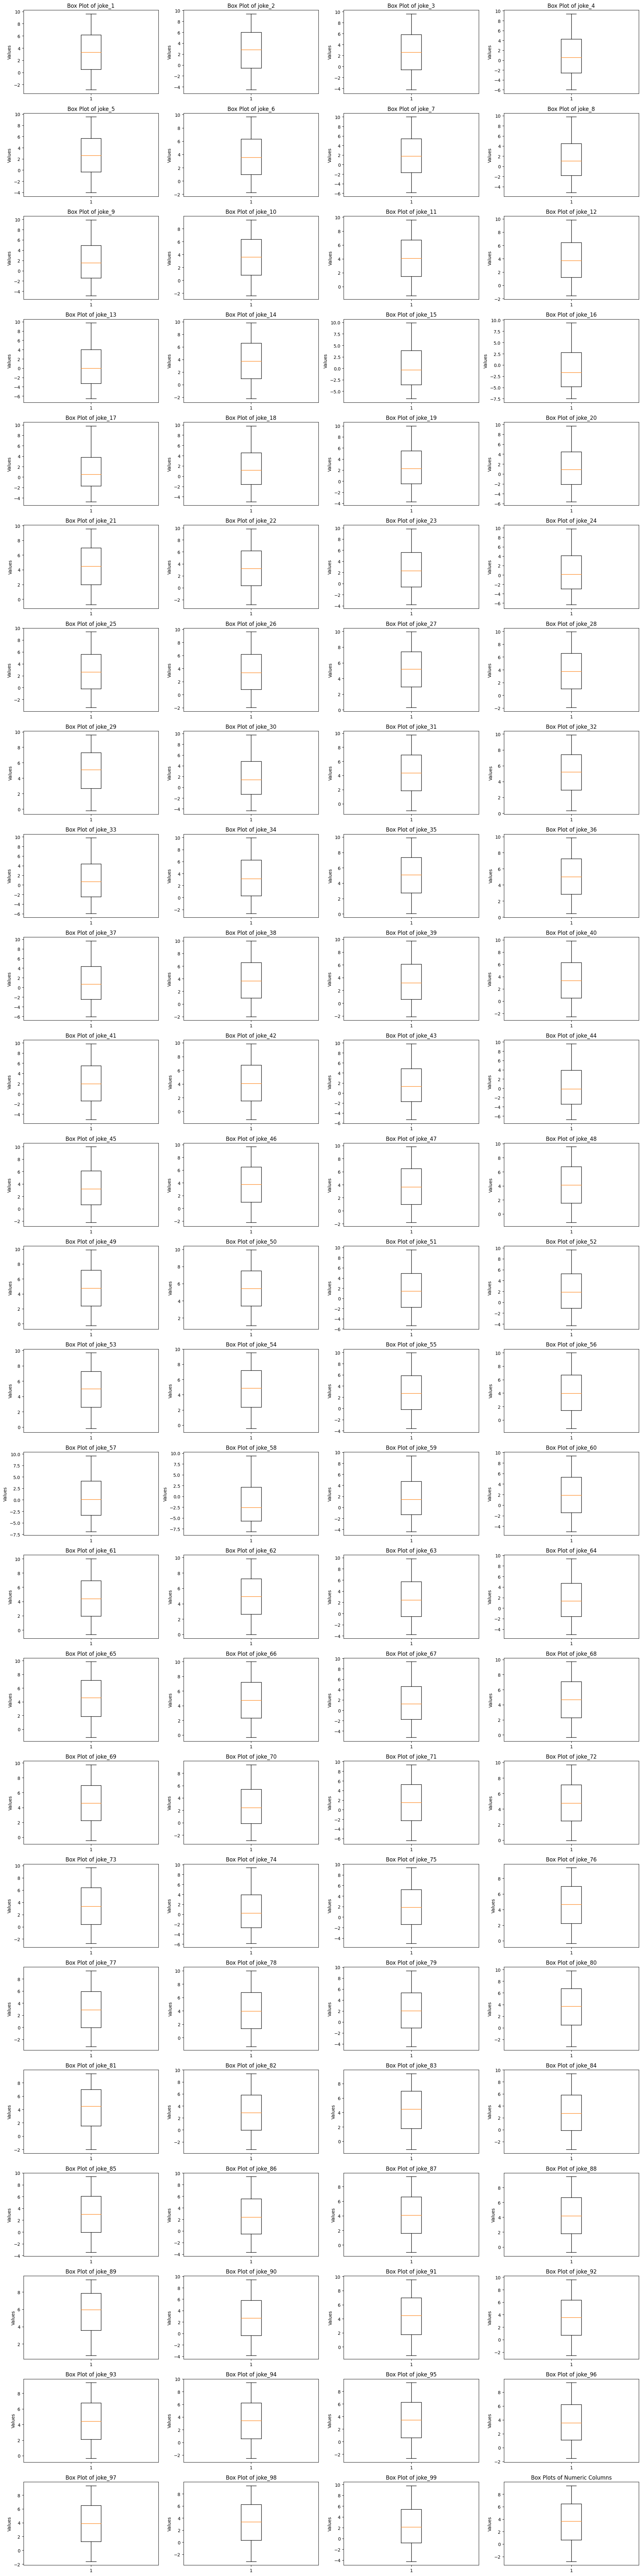

In [23]:
plot_numeric_box_plots(dataframe_without_count,description, 0)

### **After Normalization**

In [24]:
dataframe_normalized_ratings, dataframe_non_normalized_ratings = normalize_and_fill_0(dataframe_merged_ratings)
display(dataframe_normalized_ratings)

print("After Normalization")
description_normalized = perform_eda(dataframe_normalized_ratings)

# Save the description to a CSV file
description_normalized.to_csv('EDA/description_normalized_ratings.csv')

Normalization Done by replacing NANs with 0s.
Non Normalized but NANs replaced with 0s.


,user_id,number_of_jokes_rated,joke_1,joke_2,joke_3,joke_4,joke_5,joke_6,joke_7,joke_8,...,joke_91,joke_92,joke_93,joke_94,joke_95,joke_96,joke_97,joke_98,joke_99,joke_100
0,1,74.0,-0.125410,0.140966,-0.154918,-0.130863,-0.120599,-0.136315,-0.157965,0.066875,...,0.045225,0.000000,0.000000,0.000000,0.000000,0.000000,-0.090289,0.000000,0.000000,0.000000
1,2,100.0,0.073120,-0.005197,0.113981,0.078317,-0.042653,-0.173122,-0.013083,-0.095701,...,0.050539,-0.088712,-0.005197,0.140863,-0.003405,-0.038352,0.054840,0.006093,-0.077421,0.019176
2,3,49.0,0.000000,0.000000,0.000000,0.000000,0.160645,0.164915,0.160645,0.164915,...,0.000000,0.000000,0.000000,0.161535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,48.0,0.000000,0.215072,0.000000,0.000000,0.046363,0.210178,-0.072635,0.159952,...,0.000000,0.000000,0.000000,0.013651,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,91.0,0.164344,0.089133,-0.080625,-0.104214,0.026295,0.030935,0.136116,0.089133,...,0.100347,0.107887,0.082559,0.100347,0.110787,0.029969,0.060131,0.126642,0.034802,0.030935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73416,73417,21.0,0.000000,0.000000,0.000000,0.000000,0.151496,0.221478,0.000000,0.214925,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
73417,73418,16.0,0.000000,0.000000,0.000000,0.000000,0.196177,0.000000,0.000000,0.212650,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
73418,73419,35.0,0.000000,0.000000,0.000000,0.000000,-0.118579,0.000000,-0.272460,-0.080561,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
73419,73420,21.0,0.000000,0.000000,0.000000,0.000000,0.235781,0.241789,0.000000,0.229524,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


After Normalization
Summary Statistics:


,user_id,number_of_jokes_rated,joke_1,joke_2,joke_3,joke_4,joke_5,joke_6,joke_7,joke_8,...,joke_91,joke_92,joke_93,joke_94,joke_95,joke_96,joke_97,joke_98,joke_99,joke_100
count,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000,...,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000,73421.000000
mean,36711.000000,56.337560,0.008442,0.001295,0.001956,-0.012780,0.004320,0.016076,-0.021041,-0.033080,...,0.011118,0.006237,0.013826,0.006395,0.006225,0.008342,0.009380,0.005091,-0.000918,0.005785
std,21194.961394,29.015686,0.071322,0.082276,0.073752,0.069560,0.158020,0.078509,0.165999,0.151423,...,0.064262,0.062005,0.060651,0.062507,0.063312,0.059760,0.063519,0.066005,0.064493,0.053622
min,1.000000,15.000000,-0.386086,-0.546908,-0.472722,-0.436302,-0.755720,-0.405970,-0.703223,-0.768523,...,-0.623751,-0.709303,-0.494920,-0.506156,-0.609064,-0.534656,-0.472461,-0.582929,-0.520115,-0.426037
25%,18356.000000,29.000000,0.000000,0.000000,0.000000,0.000000,-0.116793,0.000000,-0.154488,-0.143756,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36711.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.026830,0.000000,-0.007338,-0.018769,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55066.000000,75.000000,0.013361,0.009875,0.000000,0.000000,0.120523,0.059416,0.109690,0.078813,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,73421.000000,100.000000,0.354335,0.438057,0.343277,0.322166,0.684337,0.407074,0.743273,0.632609,...,0.622403,0.554538,0.459699,0.607401,0.488804,0.461349,0.481635,0.743529,0.533150,0.409129



Missing Value Analysis:


Series([], dtype: int64)

In [25]:
dataframe_without_count = dataframe_normalized_ratings.copy()
dataframe_without_count = dataframe_without_count.drop(columns=['number_of_jokes_rated'])
dataframe_without_count.columns= ['user_id'] + ['joke_'+str(i+1) for i in range(100)]

#### **Histograms**

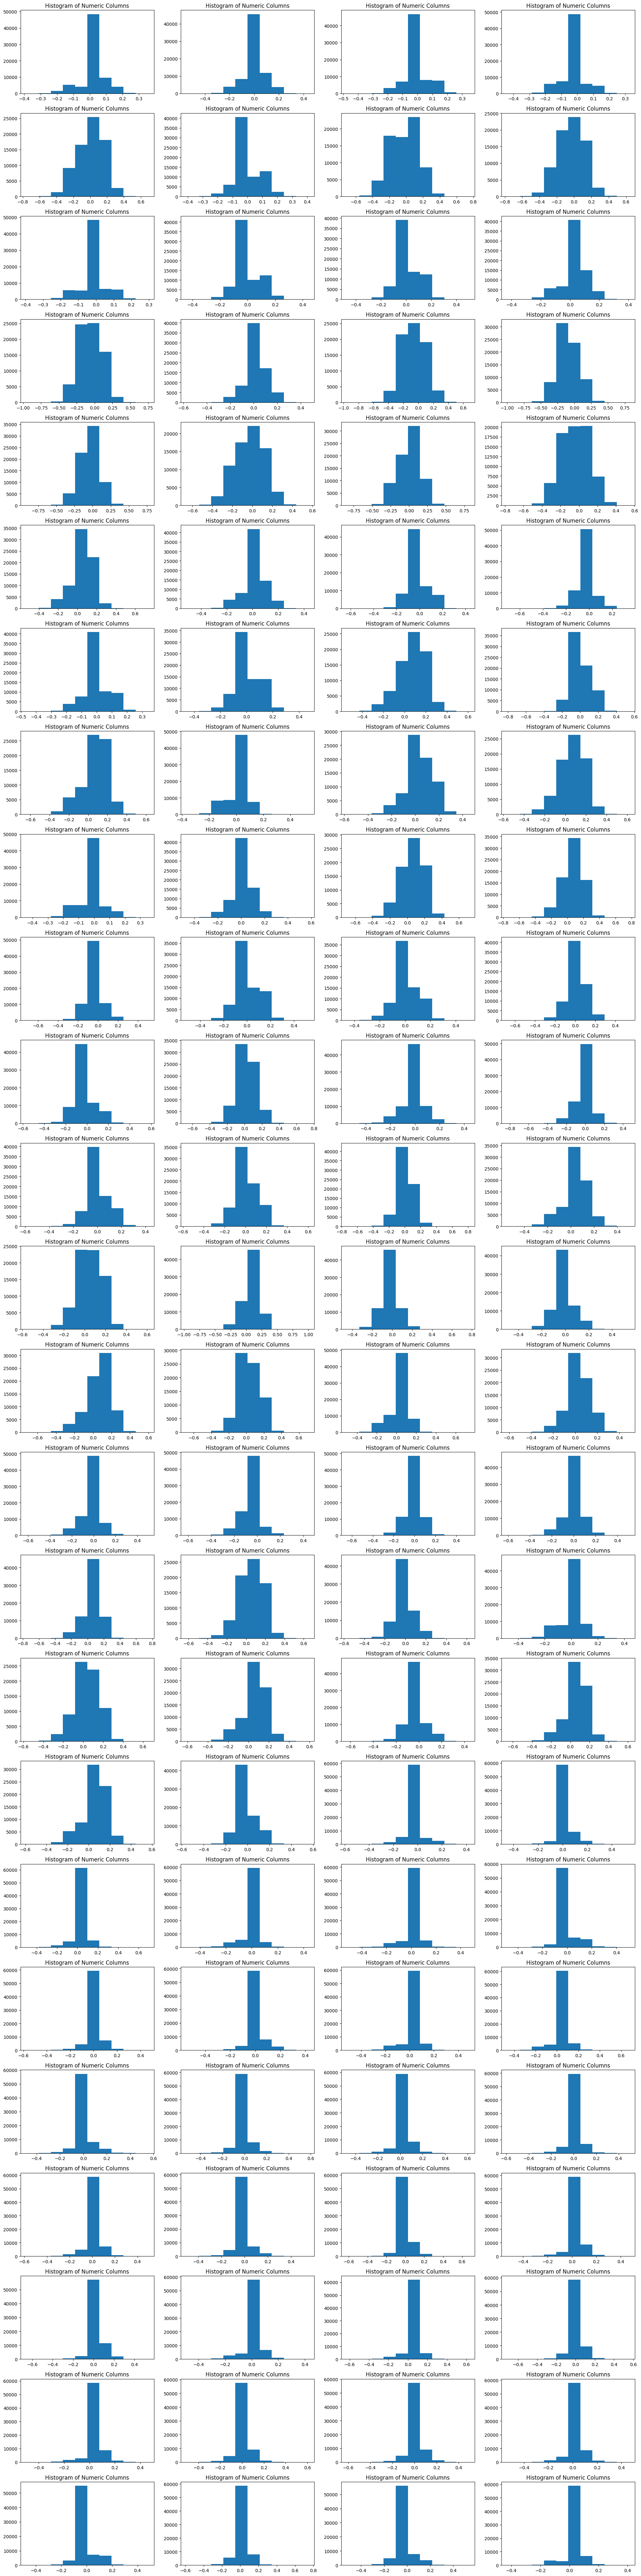

In [26]:
histograms = plot_numeric_histograms(dataframe_normalized_ratings, 1)

#### **Box Plots**

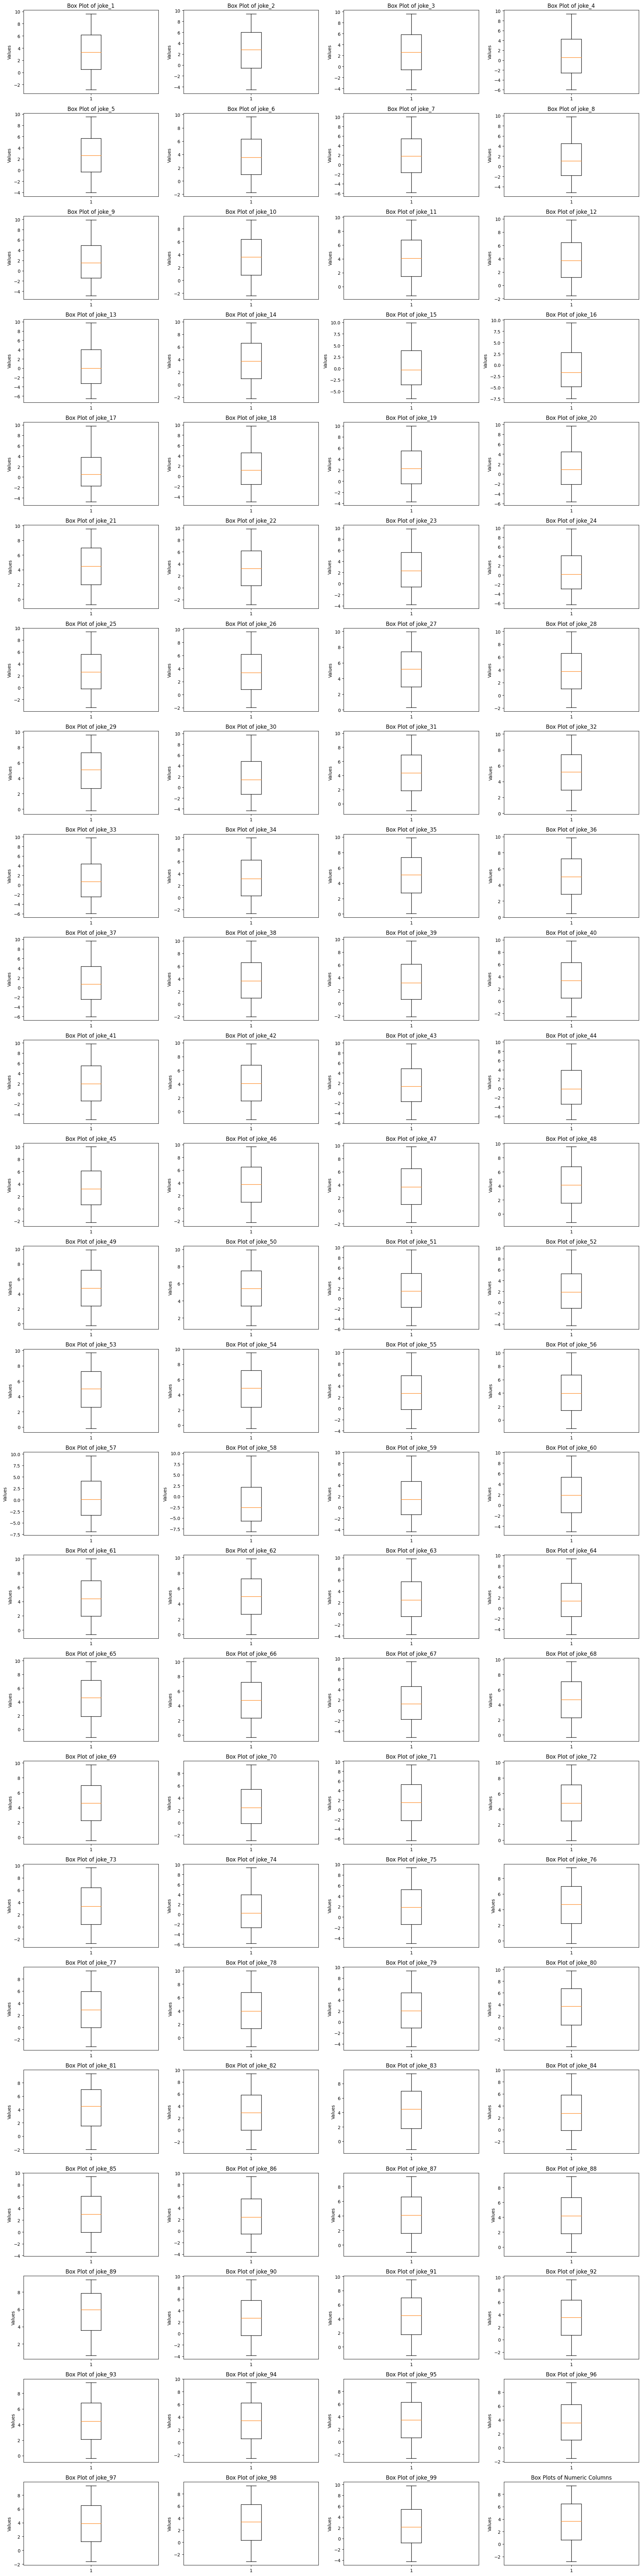

In [27]:
plot_numeric_box_plots(dataframe_normalized_ratings,description, 1)

#### **Correlation Matrix** (Waste)

In [28]:
# plot_correlation_matrix(dataframe_normalized_ratings)

In [29]:
# covarience_matrix=np.cov(dataframe_normalized_ratings.T)
# print("Covarience_matrix")
# print("Index are the column-index of dataset")
# print(dataframe_normalized_ratings.columns)
# display(pd.DataFrame(covarience_matrix))

In [30]:
# description=description.to_numpy()

In [31]:
# print("Corelation_matrix")
# corelation_matrix=covarience_matrix.copy()
# for i in range(covarience_matrix.shape[0]):
#     for j in range(covarience_matrix.shape[0]):
#         corelation_matrix[i][j]=covarience_matrix[i][j]/(description[2][i]*description[2][j])
# print("Index are the column-index of dataset")
# print(dataframe_normalized_ratings.columns)
# display(pd.DataFrame(corelation_matrix))

#### **Violin**

C:\Users\gupta\AppData\Local\Temp\ipykernel_6796\3572153745.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)


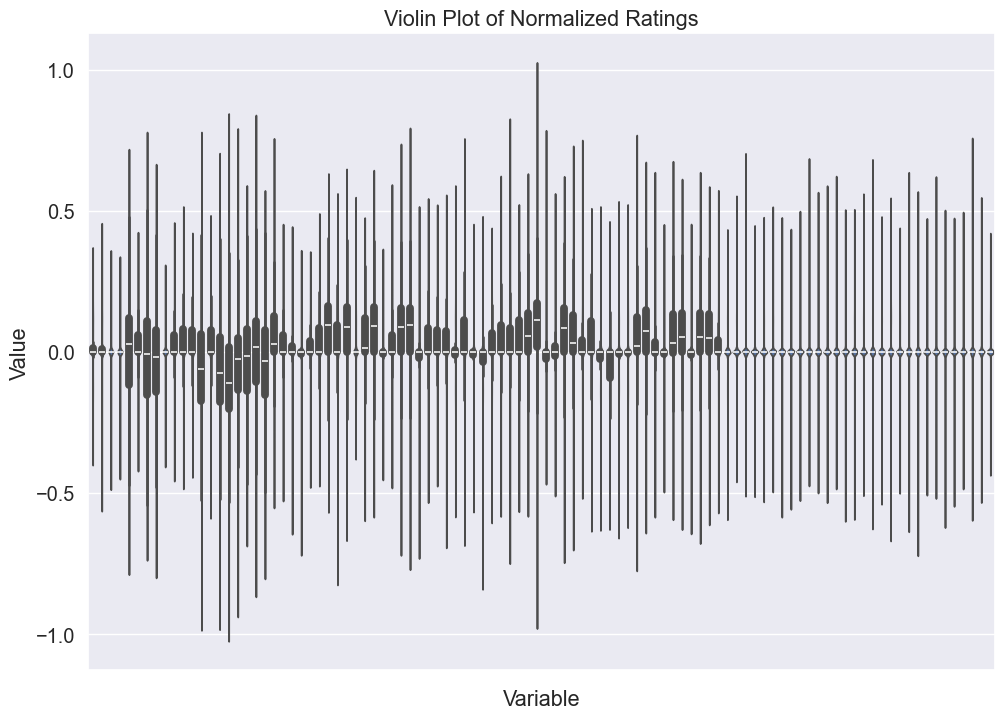

<Figure size 1170x827 with 0 Axes>

In [32]:
create_violin_plot(dataframe_normalized_ratings, "Violin Plot of Normalized Ratings", "Variable", "Value", rotation=90)

# Save the violin plot to a PDF file
plt.savefig('EDA/violin_plot_normalized_ratings.pdf', format='pdf', bbox_inches='tight')

## **EDA: Jokes**

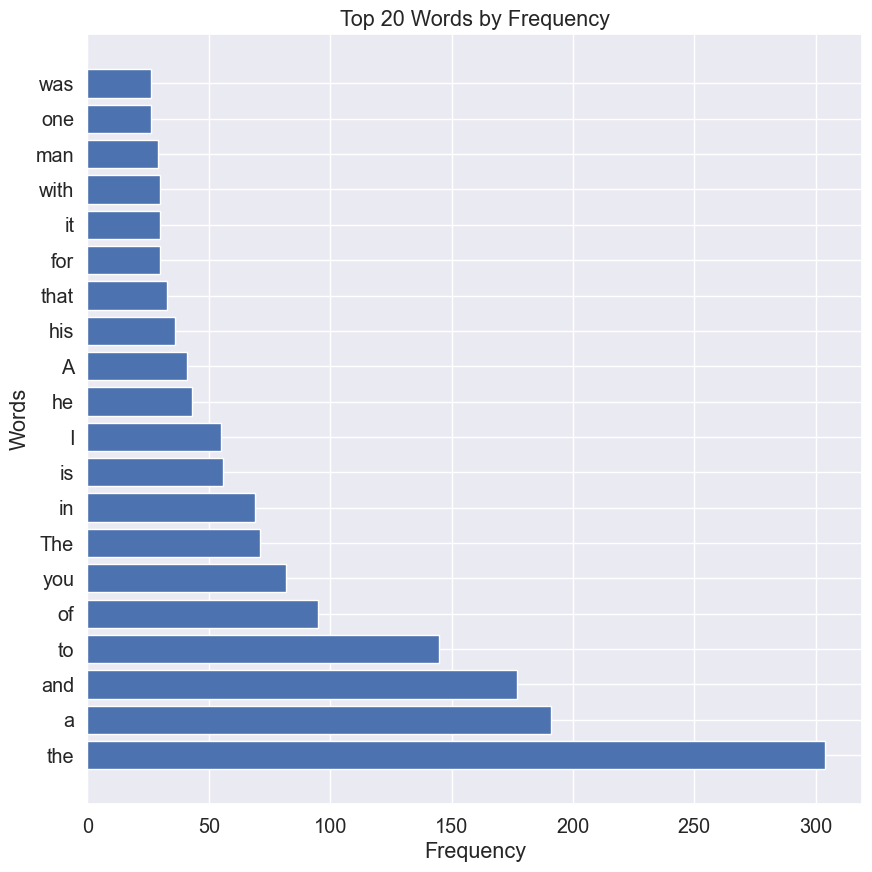

<Figure size 1170x827 with 0 Axes>

In [33]:
# create a graph for top 20 words (by frequency) in the dataset

def create_word_frequency_graph(dataframe):
    """
    Create a graph for top 20 words (by frequency) in the dataset

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing jokes.

    Returns:
    None
    """
    # create a dictionary of words and their frequency
    words = {}
    for joke in dataframe['joke']:
        for word in joke.split():
            if word in words:
                words[word] += 1
            else:
                words[word] = 1

    # sort the dictionary by frequency
    words = dict(sorted(words.items(), key=lambda item: item[1], reverse=True))

    # create a list of top 20 words
    top_20_words = list(words.keys())[:20]

    # create a list of top 20 words' frequencies
    top_20_words_frequencies = list(words.values())[:20]

    # plot the graph
    plt.figure(figsize=(10, 10))
    plt.barh(top_20_words, top_20_words_frequencies)
    plt.title("Top 20 Words by Frequency")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()

create_word_frequency_graph(dataframe_jokes)

# save the graph to a PDF file
plt.savefig('EDA/word_frequency_graph.pdf', format='pdf', bbox_inches='tight')

# **Saving..**

In [34]:
!mkdir Preprocessed

# Saving dataframe_jokes
dataframe_jokes.to_csv('Preprocessed/dataframe_jokes.csv', index=False)

# Saving LDA_dataframe_jokes
LDA_dataframe_jokes.to_csv('Preprocessed/LDA_dataframe_jokes.csv', index=False)

# Save merged dataframe
dataframe_merged_ratings.to_csv('Preprocessed/merged_ratings.csv', index=False)

# Save normalized dataframe
dataframe_normalized_ratings.to_csv('Preprocessed/normalized_ratings.csv', index=False)

# Save non-normalized dataframe
dataframe_non_normalized_ratings.to_csv('Preprocessed/non_normalized_ratings.csv', index=False)

# Save robust scaled dataframe
robust_scaled_ratings.to_csv('Preprocessed/robust_scaled_ratings.csv', index=False)

A subdirectory or file Preprocessed already exists.
